<a href="https://colab.research.google.com/github/julija-dmrk/data-mining/blob/main/1week_corrected_fish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt   # visualization
import seaborn as sns             # visualization
import numpy as np                # data manipulation
import pandas as pd               # data manipulation, data processing, CSV file I/O (e.g. pd.read_csv
# from sklearn import datasets, model_selection
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, cross_val_score, cross_validate, GridSearchCV, train_test_split

# load data
url="https://raw.githubusercontent.com/VitaT/ML-python/main/data/fish.csv"
data = pd.read_csv(url)

Exploring Data

In [2]:
# first checking for missing values
data.isnull().values.any()

False

Text(0, 0.5, 'Counts of Species')

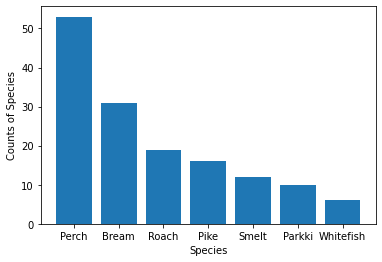

In [7]:
# exploring species distribution
sp = data["Species"].value_counts()
plt.bar(sp.index, sp, width=0.8)
plt.xlabel('Species')
plt.ylabel('Counts of Species')

In [ ]:

url="https://raw.githubusercontent.com/VitaT/ML-python/main/data/fish.csv"
data = pd.read_csv(url)
y = np.array(data["Weight"])
x = pd.get_dummies(data, columns = ['Species']).drop("Weight", axis = 1)

#y_weight = x_values[:, np.newaxis, 2]
#regr.score(y_weight, x_values)


In [ ]:
y_train, y_test, x_train, x_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=50)
regr = LinearRegression()
regr.fit(y_train, x_train)
y_pred = regr.predict(y_test)
y_pred_train = regr.predict(y_train)

r2_train = r2_score(x_train,y_pred_train)
mean_square_train = mean_squared_error(x_train, y_pred_train)

#w_bmi = regr.coef_
#i_bmi = regr.intercept_
#print('Coefficient:')
#print(w_bmi)
#print('Intercept: %.2f'% i_bmi)
# Test dataset evaluation:
print('Test Mean squared error: %.2f'% mean_squared_error(x_test, y_pred))
print('Test R-squared: %.2f' % r2_score(x_test, y_pred))
# train dataset evaluation:
print('Train Mean squared error: %.2f'% mean_squared_error(x_train, y_pred_train))
print('Train R-squared: %.2f' % r2_score(x_train, y_pred_train))

from sklearn.model_selection import cross_validate
kf = KFold(n_splits=10, shuffle=True, random_state=50)
col = 0
for col in range(y.shape[0]):
  # Create linear regression object
  print("------------------Column number " + str(col))
  scores = cross_validate(regr, y[:, np.newaxis, col], x, scoring=scoring, cv=kf, return_train_score=True)
  # scores.keys()
  # scores["test_r2"]
  # Test dataset evaluation:
  print('Test Mean squared error: %.2f'%  np.mean(abs(scores["test_neg_mean_squared_error"])))
  print('Test R-squared: %.2f' %  np.mean(scores["test_r2"]))
  # train dataset evaluation:
  print('Train Mean squared error: %.2f'%  np.mean(abs(scores["train_neg_mean_squared_error"])))
  print('Train R-squared: %.2f'  %  np.mean(scores["train_r2"]))

Test Mean squared error: 10112.38
Test R-squared: 0.93
Train Mean squared error: 8607.25
Train R-squared: 0.93


IndexError: ignored

In [ ]:
regressors = [
    LinearRegression(),
    Lasso(),
    Ridge(), 
    KNeighborsRegressor(),
    KNeighborsRegressor(n_neighbors=9, metric='manhattan')
]


In [ ]:
X__train = y_train
y__train = x_train
X__test = y_test
y__test = x_test

In [ ]:
head = 5
for model in regressors[:head]:
    model.fit(X__train, y__train)
    predictions = model.predict(X__test)
    pred_train = model.predict(X__train)
    print(model)
    print("\ttrain")
    print("\tExplained variance:", explained_variance_score(y__train, pred_train))
    print("\tMean squared error:", mean_squared_error(y__train, pred_train))
    print("\tR2 score:", r2_score(y__train, pred_train))
    print("\ttest")
    print("\tExplained variance:", explained_variance_score(y__test, predictions))
    print("\tMean squared error:", mean_squared_error(y__test, predictions))
    print("\tR2 score:", r2_score(y__test, predictions))
    print()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
	train
	Explained variance: 0.9334739593926334
	Mean squared error: 8607.254669384445
	R2 score: 0.9334739593926334
	test
	Explained variance: 0.9264654153165548
	Mean squared error: 10112.376692994363
	R2 score: 0.9260251886831783

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
	train
	Explained variance: 0.9298643262521638
	Mean squared error: 9074.275273938993
	R2 score: 0.9298643262521638
	test
	Explained variance: 0.9273959000375028
	Mean squared error: 9937.654668517744
	R2 score: 0.9273033282527322

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
	train
	Explained variance: 0.9297221420522728
	Mean squared error: 9092.671312651815
	R2 score: 0.9297221420522728
	test
	Ex

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85425.33875986433, tolerance: 1319.6937143137256
  positive)
